<a href="https://colab.research.google.com/github/alexiej/laboratory/blob/master/30_02_Voie_Translation_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
%load_ext autoreload
%autoreload 2

## INSTALL LIBRARIES
!pip install pydub

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from IPython.display import Audio
from scipy.io import wavfile

print("Tensorflow version: ", tf.__version__)
print("Pytorch version: ", torch.__version__)
print("GPU ON: ", torch.cuda.is_available())

from google.colab import drive
drive.mount('/content/drive')
 
!nvidia-smi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow version:  2.1.0
Pytorch version:  1.4.0
GPU ON:  True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Thu Mar 19 10:13:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+-------------

#### **!!! IMPORTANT !!!**

---

If you run this first time, uncomment info about `git clone`, it requires 168 MB on you gdrive to get DATASET

In [0]:
#!git clone https://github.com/andabi/deep-voice-conversion.git '/content/drive/My Drive/deep-voice-conversion'
#!mkdir '/content/drive/My Drive/deep-voice-output'

!ln -s '/content/drive/My Drive/deep-voice-conversion' /content/deep-voice-conversion
!ln -s '/content/drive/My Drive/deep-voice-output' /content/deep-voice-output

FOLDER_DATASET = '/content/deep-voice-conversion/datasets/arctic'

DATASET_SOURCE = FOLDER_DATASET + '/bdl'
DATASET_DEST = FOLDER_DATASET + '/slt'

print("DATASET INPUT SOURCE:")
!ls {DATASET_SOURCE} | head -5

print("DATASET INPUT DEST:")
!ls {DATASET_DEST}   | head -5

FOLDER_OUTPUT = '/content/deep-voice-output'

print("DATASET AND MODEL OUTPUT:")
!ls {FOLDER_OUTPUT}

DATASET INPUT SOURCE:
arctic_a0001.wav
arctic_a0002.wav
arctic_a0003.wav
arctic_a0004.wav
arctic_a0005.wav
DATASET INPUT DEST:
arctic_a0001.wav
arctic_a0002.wav
arctic_a0003.wav
arctic_a0004.wav
arctic_a0005.wav
DATASET AND MODEL OUTPUT:


## 2.0 Files / Utilities

In [0]:
%%writefile hparams.py

from types import SimpleNamespace

DEFAULT_FS = 22050
SAMPLE_RATE = DEFAULT_FS

hparams = SimpleNamespace(
    # for spectogram
    preemphasis=0.97,
    max_abs_value=4,
    power=1.5,
    griffin_lim_iters=60,

    #for melspectogram
    num_freq=513,

    # Audio:
    sample_rate=DEFAULT_FS,

    # this is only valid for mulaw is True
    silence_threshold=2,
    num_mels=160, # double it, to fit the size
    fmin=125,
    fmax=7600,
    fft_size=2048,

    # shift can be specified by either hop_size or frame_shift_ms
    hop_size=256,
    frame_shift_ms=None,
    min_level_db=-100,
    ref_level_db=20,
)

Writing hparams.py


In [0]:
from hparams import hparams, DEFAULT_FS,SAMPLE_RATE 

## 2.1 wavutils.py

In [0]:
%%writefile wavutils.py
from hparams import hparams, DEFAULT_FS,SAMPLE_RATE 

import os
import argparse
import sys

import matplotlib.pyplot as plt

from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
from IPython.display import Audio
import numpy as np
import sys

import librosa
from scipy.io import wavfile
from scipy import signal

# ==== HELPERS===============================================

# Based on https://github.com/librosa/librosa/issues/434
def _griffin_lim(S):
    angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
    S_complex = np.abs(S).astype(np.complex)
    for i in range(hparams.griffin_lim_iters):
        if i > 0:
            angles = np.exp(1j * np.angle(_stft(y)))
        y = _istft(S_complex * angles)
    return y


def _stft(y):
    return librosa.stft(y=y, n_fft=hparams.fft_size, hop_length=get_hop_size())


def _istft(y):
    return librosa.istft(y, hop_length=get_hop_size())


# Conversions:

_mel_basis = None
_inv_mel_basis = None


def _linear_to_mel(spectrogram):
    global _mel_basis
    if _mel_basis is None:
        _mel_basis = _build_mel_basis()
    return np.dot(_mel_basis, spectrogram)


def _mel_to_linear(mel_spectrogram):
    global _inv_mel_basis
    if _inv_mel_basis is None:
        _inv_mel_basis = np.linalg.pinv(_build_mel_basis())
    return np.maximum(1e-10, np.dot(_inv_mel_basis, mel_spectrogram))


def _build_mel_basis(n_mels=hparams.num_mels):
    # n_fft = (hparams.num_freq - 1) * 2
    return librosa.filters.mel(hparams.sample_rate,
                                hparams.fft_size,
                               fmin=hparams.fmin, fmax=hparams.fmax,
                               n_mels=n_mels)


def _amp_to_db(x):
    return 20 * np.log10(np.maximum(1e-5, x))


def _db_to_amp(x):
    return np.power(10.0, x * 0.05)


def _preemphasis(x):
    return signal.lfilter([1, -hparams.preemphasis], [1], x)


def _inv_preemphasis(x):
    return signal.lfilter([1], [1, -hparams.preemphasis], x)


def _normalize(S):
    return np.clip(
        (2 * hparams.max_abs_value) * ((S - hparams.min_level_db) / (-hparams.min_level_db)) - hparams.max_abs_value,
        -hparams.max_abs_value, hparams.max_abs_value)


def _denormalize(D):
    return (((np.clip(D, -hparams.max_abs_value,
                      hparams.max_abs_value) + hparams.max_abs_value) * -hparams.min_level_db / (
                     2 * hparams.max_abs_value))
            + hparams.min_level_db)


def get_hop_size():
    hop_size = hparams.hop_size
    if hop_size is None:
        assert hparams.frame_shift_ms is not None
        hop_size = int(hparams.frame_shift_ms / 1000 * hparams.sample_rate)
    return hop_size



# ===================================================== WAV
def wav_open(file):
    # data = wavfile.read(file)
    x,fs = librosa.load(file, sr=DEFAULT_FS)

    # Separete the object elements
    time      = np.arange(0,len(x))/fs
    wavdata = {
        'framerate': fs,
        'sounddata': x,
        'time': time
    }
    return wavdata


# ===================================================== SPECTOGRAM
def wav_to_spec(y):
    D = _stft(_preemphasis(y))
    S = _amp_to_db(np.abs(D)) - hparams.ref_level_db
    return _normalize(S)
    

def spec_to_wav(spectrogram):
    S = _db_to_amp(_denormalize(spectrogram) + hparams.ref_level_db)  # Convert back to linear
    return _inv_preemphasis(_griffin_lim(S ** hparams.power))  # Reconstruct phase


def spec_plot(spec_arr):
    plt.imshow(np.log(spec_arr)) # we need to logarithm soectogram to show.
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [ms]')
    plt.show()


# ===================================================== MEL SPECTOGRAM
def wav_to_mel(y, n_mels=hparams.num_mels):
    D = _stft(_preemphasis(y))
    if n_mels==hparams.num_mels:
        S = _amp_to_db(_linear_to_mel(np.abs(D)))
    else:
        _mel_basis = _build_mel_basis(n_mels)
        S = _amp_to_db(np.dot(_mel_basis, np.abs(D)))
    return _normalize(S)

def mel_to_wav(melspectrogram, n_mels=hparams.num_mels):
    if n_mels==hparams.num_mels:
        S = _mel_to_linear(_db_to_amp(_denormalize(melspectrogram)))  # Convert back to linear
    else:
        inv = np.linalg.pinv(_build_mel_basis(n_mels))
        S = np.maximum(1e-10, np.dot(inv, _db_to_amp(_denormalize(melspectrogram))))
    return _inv_preemphasis(_griffin_lim(S ** 1.5))  # Reconstruct phase


def mel_plot(mel_arr):
    return plt.imshow(mel_arr)


# ===================================================== TENSORFLOW
def mel_to_tf(mel_arr):
    # mel_arr = np.transpose(mel_arr, (1, 0))
    t = torch.from_numpy(mel_arr.astype(np.float32, copy=False) )
    t = t.expand(1,t.shape[0],t.shape[1])
    return t

def tf_to_mel(tf_arr):
    return tf_arr[0,:,:].cpu().numpy()

# =================================== WAVSHOW
import IPython.display as ipd


def wav_play(wavdata):
    return ipd.display(Audio(wavdata['sounddata'],rate=wavdata['framerate']))

def file_play(file):
    return wav_play(wav_open(file))

def files_play(files):
    for f in files:
      wav_play(wav_open(f))

def wav_show(wavdata):
    x = wavdata['sounddata']
    fs = wavdata['framerate']

    ax = plt.subplot(311)
    plt.title('Spectrogram of a wav file')
    plt.plot(x)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')

    plt.subplot(312)
    plt.specgram(x,Fs=fs)
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    ax = plt.subplot(313)
    mel_array = wav_to_mel(x)
    plt.imshow(mel_array, aspect="auto")
    plt.xlabel('Time') 
    plt.ylabel('Mel-Spec')

    plt.show()
    return ipd.display(Audio(x,rate=fs))

def files_show(files):
    for f in files:
        wavdata = wav_open(f)
        wav_show(wavdata)

Writing wavutils.py


In [0]:
from wavutils import files_show, files_play, wav_show, wav_open

files_play(
    [DATASET_SOURCE+'/arctic_a0001.wav', 
     DATASET_DEST+'/arctic_a0001.wav'])

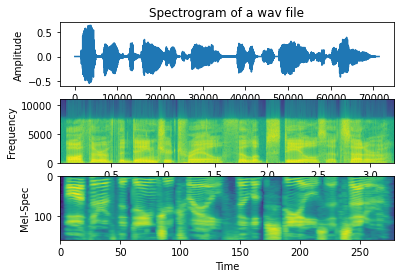

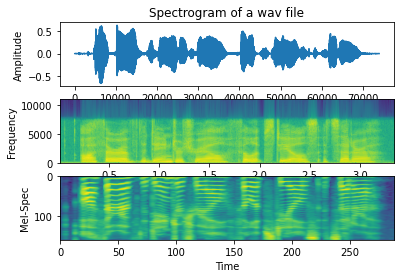

In [0]:
files_show([DATASET_SOURCE+'/arctic_a0001.wav', 
     DATASET_DEST+'/arctic_a0001.wav'])

# 3.0 Model

## 3.1 CNN Model

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

class CNNModel(nn.Module):
		def __init__(self):
			super(CNNModel, self).__init__()
			self.cnn1 = nn.Conv1d(in_channels=1025, out_channels=4096, kernel_size=3, stride=1, padding=1)
			#self.nl1 = nn.ReLU()
			#self.pool1 = nn.AvgPool1d(kernel_size=5)
			#self.fc1 = nn.Linear(4096*2500,2**5)
			#self.nl3 = nn.ReLU()
			#self.fc2 = nn.Linear(2**10,2**5)
		
		def forward(self, x):
			out = self.cnn1(x)
			#out = self.nl1(out)
			#out = self.pool1(out)
			out = out.view(out.size(0),-1)
			#out = self.fc1(out)
			#out = self.nl3(out)
			#out = self.fc2(out)
			return out


## 3.2 GramMatrix

In [0]:
class GramMatrix(nn.Module):

	def forward(self, input):
		a, b, c = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)
		features = input.view(a * b, c)  # resise F_XL into \hat F_XL
		G = torch.mm(features, features.t())  # compute the gram product
        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
		return G.div(a * b * c)


## 3.3 StyleLoss

In [0]:
class StyleLoss(nn.Module):

	def __init__(self, target, weight):
		super(StyleLoss, self).__init__()
		self.target = target.detach() * weight
		self.weight = weight
		self.gram = GramMatrix()
		self.criterion = nn.MSELoss()

	def forward(self, input):
		self.output = input.clone()
		self.G = self.gram(input)
		self.G.mul_(self.weight)
		self.loss = self.criterion(self.G, self.target)
		return self.output

	def backward(self,retain_graph=True):
		self.loss.backward(retain_graph=retain_graph)
		return self.loss
    
print(GramMatrix()(torch.Tensor([[[1,2,3]]])))

tensor([[4.6667]])


## 4.0 DataLoad

In [0]:
import glob
from tqdm import tqdm

def load_folder(folder,ext = "wav",outputfle="output.pkl"):
    l = []
    for f in tqdm(glob.glob(folder+"/*."+ ext)):
      l.append(wav_open(f))
    pickle.dump(wav_files,open(DATASET_SOURCE+"/" + outputfle,"wb"))
    return l

wav_styles = load_folder(DATASET_SOURCE)
wav_content = load_folder(DATASET_DEST)

100%|██████████| 1132/1132 [20:21<00:00,  1.00s/it]


In [0]:
import pickle
pickle.dump(wav_files,open(DATASET_SOURCE+"/output.pkl","wb"))

In [0]:
%%time
a = pickle.load(open(DATASET_SOURCE+"/output.pkl","rb"))

CPU times: user 355 ms, sys: 495 ms, total: 849 ms
Wall time: 1.56 s


In [0]:
file_style = DATASET_SOURCE+'/arctic_a0001.wav'
file_content =   DATASET_DEST+'/arctic_a0001.wav'

wav_style = wav_open(file_style)
wav_content = wav_open(file_content)

style_audio, style_sr = wav_style['sounddata'],wav_style['framerate']
content_audio, content_sr = wav_content['sounddata'],wav_content['framerate']

if(content_sr == style_sr):
  print('Sampling Rates are same: ', style_sr)
else:
  print('Sampling rates are NOT same')

Sampling Rates are same:  22050


In [0]:
#num_samples=style_audio.shape[1]	
	
#style_audio = style_audio.reshape([1,1025,num_samples])
#content_audio = content_audio.reshape([1,1025,num_samples])